<a href="https://colab.research.google.com/github/tylerdn7/project-445/blob/master/Lanl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install kaggle

!pip install numpy==1.15.0

!pip install catboost

In [0]:
import pandas as pd

import numpy as np

import io

import os

import xgboost as xgb

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import SGDRegressor

from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor, Pool

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from sklearn.svm import NuSVR, SVR

import matplotlib.pyplot as plt

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [0]:
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 14.3MB/s]
 91% 219M/242M [00:01<00:00, 125MB/s]
100% 242M/242M [00:02<00:00, 125MB/s]
100% 2.03G/2.03G [00:36<00:00, 39.6MB/s]



In [0]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
signal = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [0]:
signal.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [0]:

#Data Types of given signal

signal.dtypes

acoustic_data        int16
time_to_failure    float64
dtype: object

In [0]:
# Statistical Analysis of data

signal.describe()

,acoustic_data,time_to_failure
count,6.000000e+06,6.000000e+06
mean,4.545660e+00,1.350958e+00
std,2.277303e+01,2.533610e+00
min,-4.621000e+03,7.954798e-04
25%,2.000000e+00,3.902964e-01
50%,5.000000e+00,7.796974e-01
75%,7.000000e+00,1.169098e+00
max,3.252000e+03,1.154080e+01


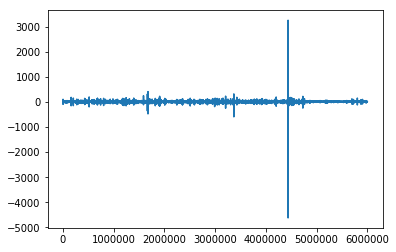

In [0]:

# Plot Acoustic data

plt.plot(signal['acoustic_data'].values)
plt.show()

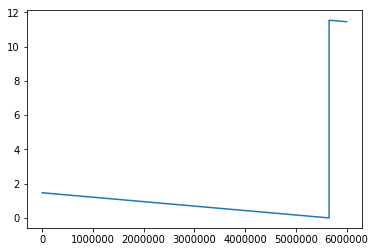

In [0]:
# plot time to failure

plt.plot(signal['time_to_failure'].values)
plt.show()

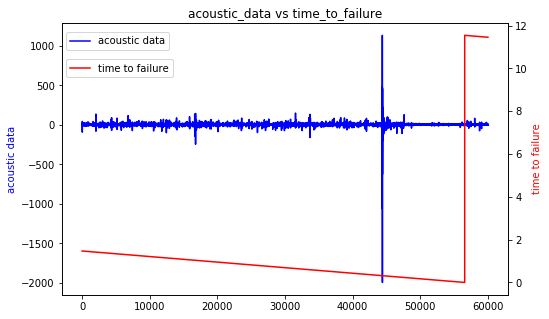

In [0]:
# Acoustic-data vs time-to-failure

fig, ax1 = plt.subplots(figsize=(8,5))
plt.title('acoustic_data vs time_to_failure')
plt.plot(signal['acoustic_data'].values[::100], color='b')
ax1.set_ylabel('acoustic data', color='b')
plt.legend(['acoustic data'], loc=(0.01, 0.9))
ax2 = ax1.twinx()
plt.plot(signal['time_to_failure'].values[::100], color='r')
ax2.set_ylabel('time to failure', color='r')
plt.legend(['time to failure'], loc=(0.01, 0.8))
plt.show()

In [0]:
rows = 150000
segments = int(np.floor(signal.shape[0] / rows))
segments
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

In [0]:
train_X.to_csv('statistical_features.csv', header=True, index=False) 


In [0]:
train_y.to_csv('output.csv', header=True, index=False) 


In [0]:
!unzip test.zip

In [0]:
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [0]:
train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.7836623258199857}}

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

clf = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
clf.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = clf.predict(X_train_scaled)

MAE_SVR = mean_absolute_error(y_train,y_pred1)

In [0]:
print (MAE_SVR)

2.094214896368042


In [0]:
grid_hyperparameter = [{'n_estimators'  : [10,20,30],'max_depth':[5,10]}]

clf = GridSearchCV(RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3), grid_hyperparameter, cv=2)
clf.fit(X_train,y_train)

clf_nr = clf.best_estimator_.get_params()['n_estimators']
clf_depthr = clf.best_estimator_.get_params()['max_depth']

print(clf_nr,clf_depthr)


NameError: ignored

In [0]:
clf_RF = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=clf_nr,max_depth = clf_depthr)
clf_RF.fit(X_train_scaled,y_train.values.flatten())

y_pred = clf_RF.predict(X_train_scaled)
MAE_RF = mean_absolute_error(y_train,y_pred)

In [0]:
print(MAE_RF)

2.086738131674921


In [0]:
Grid_Parameters = {'alpha' : [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

clf_linear = GridSearchCV(SGDRegressor(loss = "squared_loss", penalty = "l2"),Grid_Parameters,cv =5)
clf_linear.fit(X_train,y_train)
alpha = clf_linear.best_params_["alpha"]

print(alpha)

In [0]:
clf_linear = SGDRegressor(loss = "squared_loss", penalty = "l2", alpha = alpha)
clf_linear.fit(X_train,y_train)

y_pred = clf_linear.predict(X_train_scaled)
MAE_Linear = mean_absolute_error(y_train,y_pred)

In [0]:
print(MAE_Linear)

353705641642.5836


In [0]:
from prettytable import PrettyTable
    
Table = PrettyTable()

Table.field_names  = ["Model","MAE"]


Table.add_row(["CatboostRegressor", m.best_score_])
Table.add_row(["Random Forest",MAE_RF])
Table.add_row(["SVR",MAE_SVR])


print(Table)

+-------------------+----------------------------------------+
|       Model       |                  MAE                   |
+-------------------+----------------------------------------+
| CatboostRegressor | {'learn': {'MAE': 1.7836623258199857}} |
|   Random Forest   |           2.086738131674921            |
|        SVR        |           2.094214896368042            |
+-------------------+----------------------------------------+
